# Requirements and Imports

In [1]:
%pip install --quiet -r requirements.txt


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns

from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from dataset import RichHDF5Dataset, HDF5Dataset, split_strategy, reduce_sets
from network import Net
from losses import make_cost_matrix, qwk_loss, ordinal_distance_loss
from metrics import np_quadratic_weighted_kappa, ccr, ms, mae, accuracy_oneoff, from_obdout_to_labels
from utilities import plot_fsplit_info, plot_psplit_info

ImportError: cannot import name 'from_obdout_to_labels' from 'metrics' (/Users/edoardoconti/Tesi/us-ordinal-classification/metrics.py)

In [3]:
# Set the device to GPU 
gpu = len(tf.config.list_physical_devices('GPU'))>0
if gpu: 
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0],tf.config.list_physical_devices('CPU')[0]])
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU acceleration available.") 

GPU acceleration available.


# Settings

In [4]:
# ============== settings ==============
dataset_h5 = "/Users/edoardoconti/Tesi/iclus/dataset.h5"
pkl_framesmap = "/Users/edoardoconti/Tesi/iclus/hdf5_frame_index_map.pkl"
pkl_centersdict = "/Users/edoardoconti/Tesi/iclus/hospitals-patients-dict.pkl"
batch_size = 8
epochs = 2
use_less_data = True
seed = 42

# Dataset

In [5]:
# ============== dataset ===============
# Create the custom rich dataset useful for the splitting step
dataset = RichHDF5Dataset(dataset_h5, pkl_framesmap)

# Splitting the dataset into train, (validation) and test sets
split_ratios = [0.6, 0.2, 0.2]
train_subset, val_subset, test_subset, ds_info = split_strategy(dataset, ratios=split_ratios, pkl_file=pkl_centersdict, rseed=seed)

# use a smaller part of the dataset 
if use_less_data:
     train_subset, val_subset, test_subset = reduce_sets(train_subset, val_subset, test_subset, 0.15)

# Create the train, (val) and test sets to feed the neural network
train_dataset = HDF5Dataset(dataset, train_subset, batch_size, augmentation=True)
val_dataset = HDF5Dataset(dataset, val_subset, batch_size)
test_dataset = HDF5Dataset(dataset, test_subset, batch_size)

277 videos (58924 frames) loaded from cached data.
dataset split: train=35654(61%), val=11750(20%), test=11520(19%)
dataset reduction: 15% (train=5348, val=1762, test=1728)


### Class Weight

In [6]:
# Retrieves the dataset's labels
ds_labels = ds_info['labels']

# Extract the train and test set labels
y_train_labels = np.array(ds_labels)[train_subset]
y_test_labels = np.array(ds_labels)[test_subset]

# Calculate class balance using 'compute_class_weight'
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Create a dictionary that maps classes to their weights
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights: ", class_weight_dict)

Class Weights:  {0: 1.1141666666666667, 1: 0.8122721749696233, 2: 0.6989022477783586, 3: 2.269949066213922}


### Dataset Charts

In [7]:
# optional
#print_split_diagnostic_info(ds_info)
#plot_fsplit_info(ds_info, log_scale=True)
#plot_psplit_info(ds_info)

# Neural Network Model

In [8]:
model = 

2023-10-26 15:54:28.313205: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-26 15:54:28.313231: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-26 15:54:28.313234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-26 15:54:28.313533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-26 15:54:28.313841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Losses
# QWK
cost_matrix = K.constant(make_cost_matrix(ds_num_classes), dtype=K.floatx())
loss = qwk_loss(cost_matrix)
# CCE
loss = tf.keras.losses.CategoricalCrossentropy()
# ODL
loss = ordinal_distance_loss(ds_num_classes)

# Metrics
# metrics = ['accuracy']
metrics = [ccr, accuracy_oneoff, mae, ms]

# Iper-parameters
lr = 1e-2
lr_decay = 1e-6

# Compile the keras model
# model.compile(
#     #optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr),
#     optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, decay=lr_decay, momentum=0.9, nesterov=True),
#     loss=loss, 
#     metrics=metrics
# )

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), loss=loss, metrics=metrics)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

# Training Neural Network

In [10]:
history = model.fit(train_dataset, 
                    shuffle=True,
                    epochs=epochs,
                    class_weight=class_weight_dict,
                    validation_data=val_dataset
                    )

Epoch 1/2


2023-10-26 15:54:31.737466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


669/669 [==============================] - 431s 637ms/step - loss: 1.3285 - ccr: 0.4112 - accuracy_oneoff: 0.8933 - mae: 0.6960 - ms: 0.0122 - val_loss: 0.9721 - val_ccr: 0.5436 - val_accuracy_oneoff: 0.9559 - val_mae: 0.5006 - val_ms: 0.0245
Epoch 2/2
669/669 [==============================] - 421s 629ms/step - loss: 1.1310 - ccr: 0.4856 - accuracy_oneoff: 0.9410 - mae: 0.5738 - ms: 0.0551 - val_loss: 0.9427 - val_ccr: 0.5781 - val_accuracy_oneoff: 0.9587 - val_mae: 0.4666 - val_ms: 0.1293


<function matplotlib.pyplot.show(close=None, block=None)>

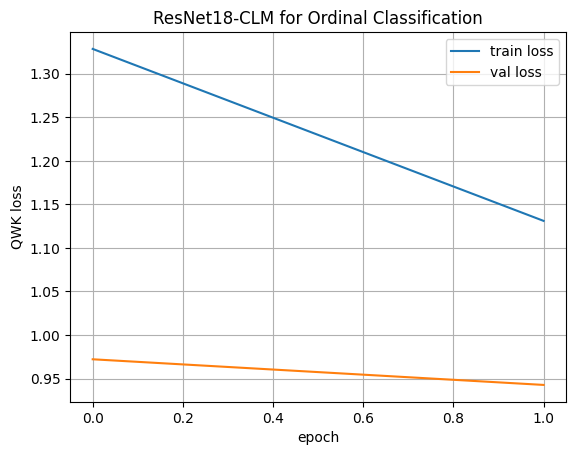

In [11]:
# Plot Training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('QWK loss')
plt.title('ResNet18-CLM for Ordinal Classification')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

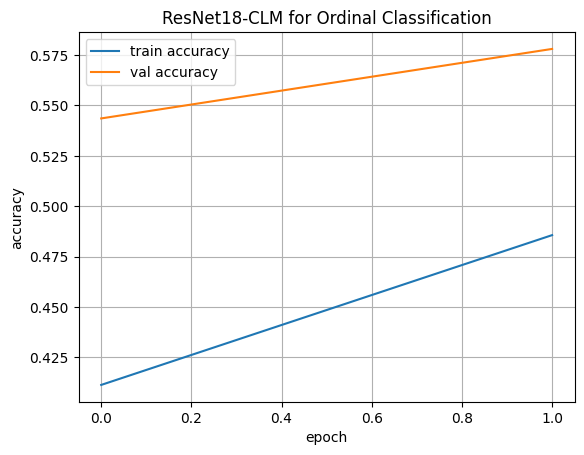

In [13]:
# Plot Training accuracy
plt.plot(history.history['ccr'], label='train accuracy')
plt.plot(history.history['val_ccr'], label='val accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ResNet18-CLM for Ordinal Classification')
plt.grid()
plt.show

# Evaluate

In [14]:
model.evaluate(test_dataset)

216/216 [==============================] - 79s 367ms/step - loss: 0.9501 - ccr: 0.5799 - accuracy_oneoff: 0.9566 - mae: 0.4670 - ms: 0.1481


[0.9500763416290283,
 0.5798611044883728,
 0.9565972089767456,
 0.4670138955116272,
 0.148109570145607]

In [15]:
y_test_pred = model.predict(test_dataset)
# y_test_pred = np.argmax(y_test_pred, axis=1) # extract classes from probabilities

216/216 [==============================] - 82s 373ms/step


In [16]:
y_test_pred = from_obdout_to_labels(y_test_pred)

array([[0.6834412 , 0.414613  , 0.02602317],
       [0.7196101 , 0.52824724, 0.1558825 ],
       [0.8536432 , 0.90341556, 0.26338387],
       ...,
       [0.6254989 , 0.1506755 , 0.09405769],
       [0.8822111 , 0.9305506 , 0.4157566 ],
       [0.8893965 , 0.8872296 , 0.60874826]], dtype=float32)

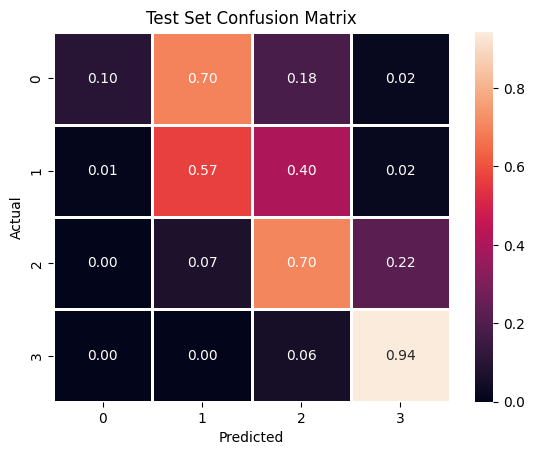

In [20]:
# Test Set Confusion Matrix
cf_matrix_test = confusion_matrix(y_test_labels, y_test_pred, normalize='true', labels=list(range(ds_num_classes)))

ax = sns.heatmap(cf_matrix_test, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Test Set Confusion Matrix')
plt.show()

In [21]:
qwk_test = np_quadratic_weighted_kappa(y_test_labels, y_test_pred, 0, ds_num_classes - 1)

print('QWK Test Set: {:.4f}'.format(qwk_test))

QWK Test Set: 0.6450
